# Informe Preliminar: Implementación de QAOA Básico para Max-Cut

**Autores:** Mauro Castillo, Javiera Osorio, Mariano Varas Ramos

**Ramo:** INF456 - Introducción a la Computación Cuántica

**Fecha:** 4 de Noviembre, 2025

## 1. Descripción del Problema que Estamos Implementando

Estamos implementando el **Quantum Approximate Optimization Algorithm (QAOA)** para resolver el problema de **Max-Cut**, el cual es un *benchmark* estándar NP-hard en optimización combinatoria. El objetivo es validar la funcionalidad de QAOA en hardware NISQ y explorar técnicas avanzadas para escalar su rendimiento y mitigar las dificultades inherentes al hardware.

Nuestra implementación se basa en los tutoriales de Qiskit [1, 2], siguiendo un flujo de trabajo de 4 pasos:

### Flujo de Trabajo de QAOA Base

**Paso 1: Mapeo Clásico $\rightarrow$ Cuántico**
1.  **Grafo $\rightarrow$ Hamiltoniano:** El problema (un grafo $G=(V, E)$) se convierte en un Hamiltoniano de costo $H_C$. Para Max-Cut, cada arista $(i, j)$ se traduce en un término de Pauli $Z_i Z_j$. Buscamos el estado (bitstring) que minimiza $\langle H_C \rangle$.
    * *Implementación:* Usamos `SparsePauliOp.from_sparse_list` [2, celda 3].

**Paso 2: Construcción y Optimización del Circuito**
1.  **Hamiltoniano $\rightarrow$ Ansatz:** Construimos el circuito variacional `QAOAAnsatz(reps=p)` [2, celda 4], que alterna $p$ capas del operador de costo $e^{-i\gamma_k H_C}$ y el mezclador $e^{-i\beta_k H_B}$.
2.  **Transpilación:** El circuito lógico se transpila usando `generate_preset_pass_manager` (level 3) para adaptarlo a la conectividad y compuertas nativas del backend [2, celda 6].

**Paso 3: Ejecución y Optimización (Bucle Híbrido)**
1.  **Primitiva `Estimator`:** Se usa el `Estimator` de Qiskit Runtime para calcular el valor esperado $\langle H_C \rangle$ [2, celda 8].
2.  **Optimizador Clásico:** Un optimizador (ej. COBYLA) ajusta los parámetros $(\vec{\gamma}, \vec{\beta})$ iterativamente para encontrar el mínimo de $\langle H_C \rangle$ [2, celda 9].

**Paso 4: Post-procesamiento y Solución**
1.  **Primitiva `Sampler`:** Con los parámetros óptimos $(\vec{\gamma}^*, \vec{\beta}^*)$, se usa el `Sampler` para obtener la distribución de probabilidad de las soluciones [2, celda 12].
2.  **Resultado:** Se extrae el bitstring más probable o el de menor energía como la solución candidata al problema de Max-Cut [2, celda 13].

---

## 2. Avance a la Fecha: Implementación Base (N=5 Nodos)

Hemos implementado y ejecutado con éxito el **flujo completo de QAOA Base** (descrito en la sección anterior) para un grafo pequeño de 5 nodos, siguiendo el tutorial [2]. Esto nos ha permitido validar cada paso del proceso.

### 2.1. Instalación de Dependencias
Primero, instalamos las librerías necesarias.

In [ ]:
!pip install 'qiskit[visualization]' -q
!pip install qiskit-ibm-runtime -q
!pip install rustworkx -q
!pip install python-sat -q
!pip install qiskit-aer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 105.4 MB/s eta 0:00:00


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence, Callable, Iterable
from dataclasses import dataclass
from itertools import combinations
from threading import Timer

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)

from pysat.formula import CNF, IDPool
from pysat.solvers import Solver

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


### 2.2. Paso 1: Mapeo Grafo $\rightarrow$ Hamiltoniano (N=5)

Grafo de N=5 nodos:


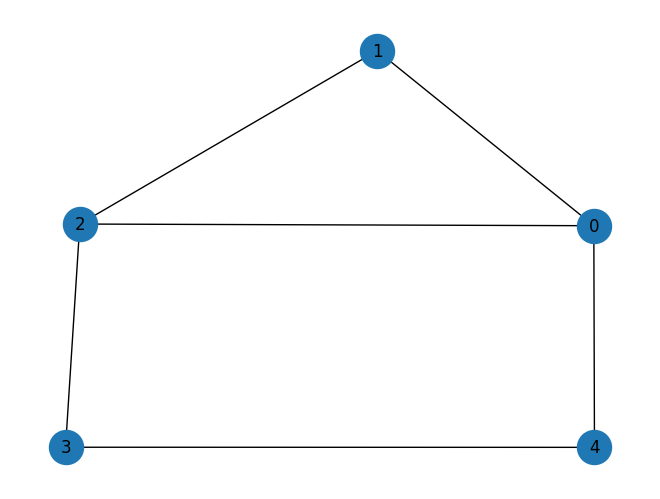

In [ ]:
n = 5
graph_5 = rx.PyGraph()
graph_5.add_nodes_from(np.arange(0, n, 1))
edge_list_5 = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph_5.add_edges_from(edge_list_5)

print("Grafo de N=5 nodos:")
draw_graph(graph_5, node_size=600, with_labels=True)

In [ ]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis_5 = build_max_cut_paulis(graph_5)
cost_hamiltonian_5 = SparsePauliOp.from_sparse_list(max_cut_paulis_5, n)

print("Cost Function Hamiltonian (H_C) para N=5:")
print(cost_hamiltonian_5.paulis.to_labels())

Cost Function Hamiltonian (H_C) para N=5:
['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII']


### 2.3. Pasos 2-4: Ansatz, Optimización y Resultados (N=5)

Construimos el `QAOAAnsatz` con $p=2$ capas, definimos la función de costo y ejecutamos el bucle de optimización.

A diferencia del tutorial [2], usaremos `qiskit_aer` (un simulador local de alto rendimiento) para ejecutar este ejemplo base. Esto es mucho más rápido para la depuración y no requiere una conexión a la nube de IBM.

In [ ]:
# --- 1. backend de aersimulator ---
from qiskit_aer.primitives import Estimator as AerEstimator, Sampler as AerSampler
from qiskit_aer import AerSimulator

print("Usando simulador local (AerSimulator) para esta implementación.")
local_backend = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=1, backend=local_backend) # nivel 1 es suficiente para simulador

# --- 2. construcción y transpilación del tircuito ---
circuit_5 = QAOAAnsatz(cost_operator=cost_hamiltonian_5, reps=2)
circuit_5.measure_all()
candidate_circuit_5 = pm.run(circuit_5)

print(f"Circuito N=5, p=2 transpiled. Profundidad: {candidate_circuit_5.depth()}")

# --- 3. definición de costo y optimización ---
objective_func_vals = []
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    results = job.result()
    cost = results.values[0]
    objective_func_vals.append(cost)
    return cost

init_params = [np.pi, np.pi / 2] * 2 # Para p=2

estimator = AerEstimator()
estimator.options.default_shots = 1024

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit_5, cost_hamiltonian_5, estimator),
    method="COBYLA",
    tol=1e-2,
)
print("Optimización finalizada:")
print(result)

Usando simulador local (AerSimulator) para este informe.
Circuito N=5, p=2 transpiled. Profundidad: 12
Optimización finalizada:
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.388671875
       x: [ 4.334e+00  1.611e+00  3.435e+00  2.742e+00]
    nfev: 25
   maxcv: 0.0


In [ ]:
# --- 4. Post-procesamiento y Muestreo ---

optimized_circuit_5 = candidate_circuit_5.assign_parameters(result.x)

sampler = AerSampler()

shots_num = 10000

job = sampler.run(circuits=[optimized_circuit_5], shots=shots_num)
results = job.result()

quasi_dist = results.quasi_dists[0]
final_distribution_bin = quasi_dist.binary_probabilities()

print(f"Distribución de probabilidades (primeros 5): {dict(list(final_distribution_bin.items())[:5])}")

counts_bin = {k: v * shots_num for k, v in final_distribution_bin.items()}
shots = sum(counts_bin.values())

Distribución de probabilidades (primeros 5): {'11000': 0.0034, '10010': 0.0482, '11100': 0.0162, '10101': 0.0461, '01101': 0.0433}


### 2.4. Resultados Obtenidos (N=5)

El flujo se ejecutó correctamente. El optimizador convergió (ver Fig. 1 Izq.), y la distribución final (Fig. 1 Centro) identifica las soluciones óptimas (`10100` y `01011` o sus opuestos bit a bit) para este grafo. (Nota: los bitstrings de Qiskit se leen de derecha a izquierda, `00101` $\equiv$ `10100`).

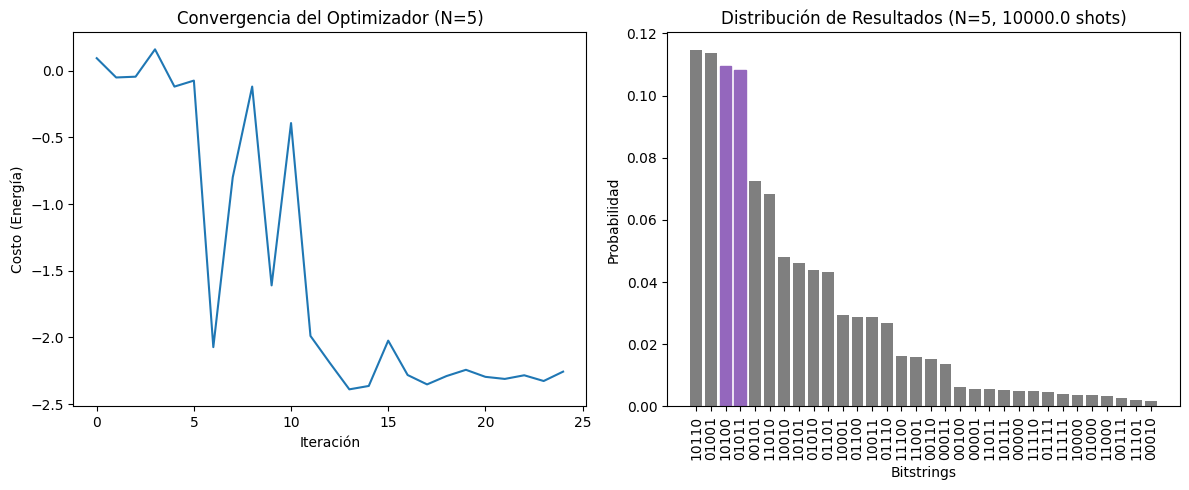

Bitstring más probable: 10110
Valor del corte: 4


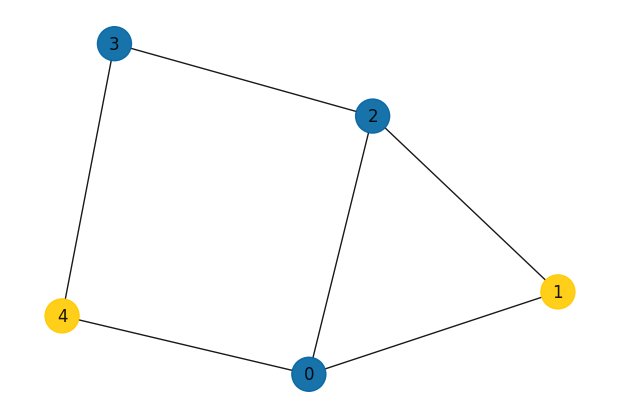

In [ ]:
# --- visualización de resultados ---

def to_bitstring_from_str(str_bits):
    return [int(digit) for digit in str_bits]

def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    # función de costo de Max-Cut (maximizar cortes)
    cut_size = 0
    for u, v in list(graph.edge_list()):
        if x[u] != x[v]:
            cut_size += 1
    return cut_size

def plot_result_graph(G, x):
    colors = ["#FFCA00" if i == 0 else "#0064a2" for i in x] # colores usm xd
    pos = rx.spring_layout(G)
    plt.figure(figsize=(6, 4))
    rx.visualization.mpl_draw(
        G, node_color=colors, node_size=600, alpha=0.9, pos=pos, with_labels=True, node_shape='o'
    )
    plt.show()

# graficar convergencia
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(objective_func_vals)
4.2. Escalación a N=100 (y má
plt.xlabel("Iteración")
plt.ylabel("Costo (Energía)")
plt.title("Convergencia del Optimizador (N=5)")

# graficar distribución final
plt.subplot(1, 2, 2)
keys_sorted = sorted(final_distribution_bin, key=final_distribution_bin.get, reverse=True)
values_sorted = [final_distribution_bin[k] for k in keys_sorted]
plt.xticks(rotation=90)
plt.title(f"Distribución de Resultados (N=5, {shots} shots)")
plt.xlabel("Bitstrings")
plt.ylabel("Probabilidad")
plt.bar(keys_sorted, values_sorted, color="tab:grey")
# resaltar las 2 soluciones óptimas (y sus opuestos)
optimal_strs = ['01011', '10100']
for i, key in enumerate(keys_sorted):
    if key in optimal_strs:
        plt.gca().get_children()[i].set_color("tab:purple")
plt.tight_layout()
plt.show()

# --- graficar mejor corte ---
most_likely_str = keys_sorted[0]
most_likely_bitstring = to_bitstring_from_str(most_likely_str)

print(f"Bitstring más probable: {most_likely_str}")
print(f"Valor del corte: {evaluate_sample(most_likely_bitstring, graph_5)}")
plot_result_graph(graph_5, most_likely_bitstring)

---

## 3. Dificultades Enfrentadas



Durante la implementación se presentaron conflictos de versiones entre las librerías utilizadas, principalmente relacionados con **Qiskit** y sus dependencias internas. En entornos como este (**Google Colab**), la versión instalada por defecto de Qiskit no contenía ciertos módulos requeridos, como `algorithm_globals` del paquete `qiskit.utils`.  

Esto provocó errores de importación como:
""cannot import name 'algorithm_globals' from 'qiskit.utils'""

y la imposibilidad de ejecutar partes del código que dependían directamente de Qiskit.

### Soluciones implementadas

- Se probaron distintas versiones de **Qiskit** para identificar combinaciones compatibles.  
- Se reemplazaron temporalmente módulos dependientes de Qiskit por **implementaciones simuladas o placeholders** en Python, con el fin de mantener la estructura del flujo de trabajo.  
- Se consideró la opción de ejecutar el proyecto en un entorno local con versiones controladas en lugar de depender completamente de **Google Colab**.  

Gracias a estas adaptaciones, fue posible continuar con el desarrollo y pruebas del sistema, asegurando que el flujo principal del programa pudiera ejecutarse correctamente aun sin la disponibilidad total de Qiskit.





---



## 4. Desafíos a Futuro (Próximos Pasos)

Nuestro trabajo preliminar (Implementación Base) ha validado el flujo. Ahora, nuestros desafíos futuros se centran en escalar la implementación y aplicar las técnicas avanzadas que abordamos en las presentaciones anteriores.

### 4.1. Implementación de técnicas avanzadas para QAOA en Max-Cut

Como hemos documentado, nuestra implementación base (N=5) funciona, pero las dificultades de transpilación ineficiente y optimización ruidosa hacen que este enfoque simple no sea escalable.

Nuestro desafío inmediato es implementar las técnicas avanzadas descritas en el tutorial [1] para abordar estos dos cuellos de botella simultáneamente. Este paso es crucial para poder ejecutar problemas de N=100 de manera significativa.



### 4.2. Escalación a N=100 (y más) en QiskitRuntimeService

Ya habiendo implementado estas técnicas el siguiente desafío es migrar nuestra implementación del simulador local (qiskit_aer) a los sistemas en la nube de IBM (QiskitRuntimeService), ya sea usando simuladores de alto rendimiento o backends de hardware real (ej. ibm_brisbane) [1].



1.   **Implementar el flujo avanzado (N=100 y casos prácticos):**

      *   **Transpilación Optimizada:** Aplicar el SATMapper [1] para encontrar el mapeo inicial óptimo y el Commuting2qGateRouter [1] para reducir la profundidad del circuito de 100 nodos, minimizando los SWAPs.

      *   **Función de Costo Robusta:** Reemplazar el valor esperado por la función de costo qaoa_sampler_cost_fun basada en **CVaR** (ej. α=0.1) [1, 3, 4]. Esto es vital para obtener una señal de costo estable del hardware ruidoso.


2.   **Benchmarking y Comparación:**


      *   Comparar la profundidad del circuito, el número de CNOTs y el tiempo de transpilación del N=100 antes (con preset_pass_manager(level=3)) y después de aplicar el SATMapper.

      *   Ejecutar el bucle de optimización en el backend de QiskitRuntimeService y comparar la convergencia (velocidad y calidad de la solución final) usando el costo CVaR [1] vs. el valor esperado estándar (de [2]).









### 4.3. Próxima Implementación de Otras Técnicas del Estado del Arte

Una vez completada y validada la implementación de la "Implementación Avanzada" (CVaR + SATMapper) en el hardware de IBM, el siguiente desafío será implementar y comparar las otras variantes de vanguardia que identificamos en nuestro estado del arte:


1.   QAOA-Warmest (Tate et al.)

2.   Circuit Cutting (Lowe et al.)

3.   Otras variantes estructurales.






---



## Referencias

[1] Qiskit Tutorial: *Advanced techniques for QAOA*. (https://quantum.cloud.ibm.com/docs/en/tutorials/advanced-techniques-for-qaoa)

[2] Qiskit Tutorial: *Quantum approximate optimization algorithm*. (https://quantum.cloud.ibm.com/docs/en/tutorials/quantum-approximate-optimization-algorithm)


[3] Tate, R. et al. (2023). *Warm-Started QAOA with Custom Mixers...* (q-2023-09-26-1121 (1).pdf)

[4] Lowe, A. et al. (2023). *Fast quantum circuit cutting...* (q-2023-03-02-934.pdf)